# 3D Transforms

In this we demonstrate 3D WarpAffine and Rotate

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

Let's define some test data - in this case, it consists of edges of a cube

In [2]:
nvidia_green = [0x76,0xb9,0.0]

def build_cube(output_shape, size, color = nvidia_green):
    color = np.array(color)
    arr = np.zeros(output_shape + [3], np.uint8)
    lo = (np.array(output_shape) - np.array(size)) * 0.5
    hi = (np.array(output_shape) + np.array(size)) * 0.5
    dims = len(output_shape)
    for d in range(dims):
        for c in range(int(np.rint(lo[d])), int(np.rint(hi[d]))):
            d0 = 0
            d1 = 1
            if d == 0:
                d0 = 1
                d1 = 2
            elif d == 1:
                d0 = 0
                d1 = 2
            p = [int(x) for x in lo]
            p[d] = c
            arr[p[0], p[1], p[2], :] = color
            p[d0] = int(np.rint(hi[d0]))
            arr[p[0], p[1], p[2], :] = color
            p[d1] = int(np.rint(hi[d1]))
            arr[p[0], p[1], p[2], :] = color
            p[d0] = int(np.rint(lo[d0]))
            arr[p[0], p[1], p[2], :] = color
    return arr

Now, let's define the pipeline.

In [3]:
class ExamplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(ExamplePipeline, self).__init__(
            batch_size, num_threads, device_id,
            seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        
        self.input = ops.ExternalSource()
       
        self.rotate_gpu = ops.Rotate(
            device = "gpu",
            axis = (0.5,1,1),
            angle = 30,
            interp_type = types.INTERP_LINEAR # use linear interpolation
        )
        self.rotate_cpu = ops.Rotate(
            device = "cpu",
            axis = (0.5,1,1),
            angle = 30,
            interp_type = types.INTERP_LINEAR # use linear interpolation
        )
        
    # Then, we can tie the operators together to form a graph
        
    def define_graph(self):
        self.data = self.input()
        outputs = [self.data.gpu()]
        # pass the transform parameters through GPU memory
        outputs += [self.rotate_gpu(self.data.gpu()), self.rotate_cpu(self.data).gpu()]

        return outputs
    
    # Since we're using ExternalSource, we need to feed the externally provided data to the pipeline
    
    def iter_setup(self):
        # Generate the transforms for the batch and feed them to the ExternalSource
        self.feed_input(self.data, [build_cube([128,128,128],[80,80,80],nvidia_green)])    

The pipeline class is now ready to use - we need to construct and build it before we run it.

In [4]:
batch_size = 1
pipe = ExamplePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

Finally, we can call `run` on our pipeline to obtain the first batch of preprocessed images.

In [5]:
pipe_out = pipe.run()

## Example output

Now that we've processed the first batch of images, let's see the results. The output is projected by taking maximum intensity values along Z axis.

(128, 128, 128, 3)
(188, 180, 200, 3)
(188, 180, 200, 3)


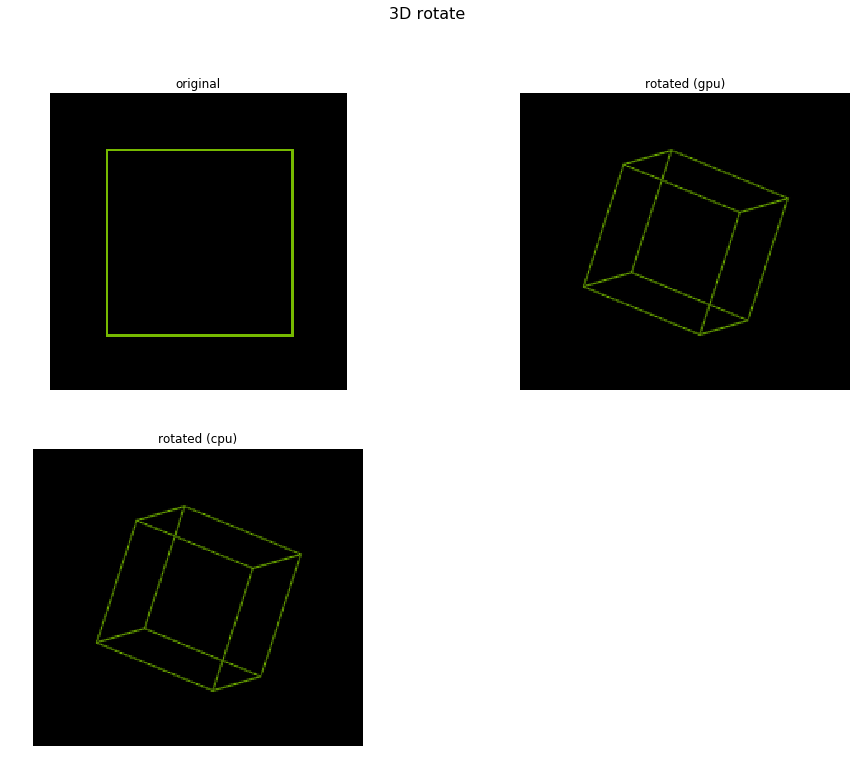

In [6]:
n = 0  # change this value to see other images from the batch;
       # it must be in 0..batch_size-1 range

def project_volume(volume):
    return np.amax(volume, axis = 0)    

from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec

len_outputs = len(pipe_out)

captions = ["original",
            "rotated (gpu)", "rotated (cpu)"]

fig = plt.figure(figsize = (16,12))
plt.suptitle("3D rotate", fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)

for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(captions[i])
    pipe_out_cpu = pipe_out[i].as_cpu()
    img = project_volume(pipe_out_cpu.at(n)) * (1 / 255.0)
    print(pipe_out_cpu.at(n).shape)
    plt.imshow(img)